## Driver code generating brain-maps

### Steps
- import stat csvs 
- visualize quantitative performance  
- visualize brain regions

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import pickle
import time
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from surfer import Brain
from mayavi import mlab

from tvtk.api import tvtk
from tvtk.common import configure_input_data

mlab.init_notebook()
mlab.options.offscreen = True

%matplotlib inline

#%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_test_dir/
%env SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects

sys.path.append('../')
from lib.plot_utils import *
from lib.data_stats import aggregate_perf

Notebook initialized with x3d backend.
env: SUBJECTS_DIR=/home/nikhil/projects/CT_reproduce/data/fs_output/subjects


### Data paths

In [37]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
common_space = data_dir + 'common_space/fsaverage/'
results_dir = data_dir + 'results/'
brainmaps_dir = results_dir + 'brainmaps/'
demograph_file = 'ABIDE_Phenotype.csv'
sm_perf_file = 'atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_auto_N_960.pkl'#'atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_manual_gleb_N_225.pkl'#'atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_manual_maarten_N_975.pkl' #'atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_No_QC_N_1047.pkl'

### Global Vars

In [38]:
subject_ID_col = 'SubjID'

### Load data

In [39]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# # Results
results_type = 'atlas' # atlas or pipeline
stat_measure = 'p_val_corr' # p_val or p_val_corr

if results_type == 'pipeline':
    stat_perf = pd.read_pickle(results_dir + sm_perf_file)
        
else:
    with open(results_dir + sm_perf_file, 'rb') as handle:
        stat_perf = pickle.load(handle)
        


### Statistical plots 

Plots based on 960 subjects
Top 5 most significant regions                    roi       coef      t_val         p_val    p_val_corr
57         R_precuneus -15.725050 -18.925147  6.925943e-68  4.709641e-66
6   L_inferiorparietal -14.462270 -18.758105  6.827285e-67  2.321277e-65
23         L_precuneus -14.765149 -18.652558  2.884935e-66  6.539187e-65
61  R_superiorparietal -14.869126 -18.579070  7.851865e-66  1.334817e-64
27  L_superiorparietal -14.880475 -18.014859  1.610223e-62  2.189903e-61


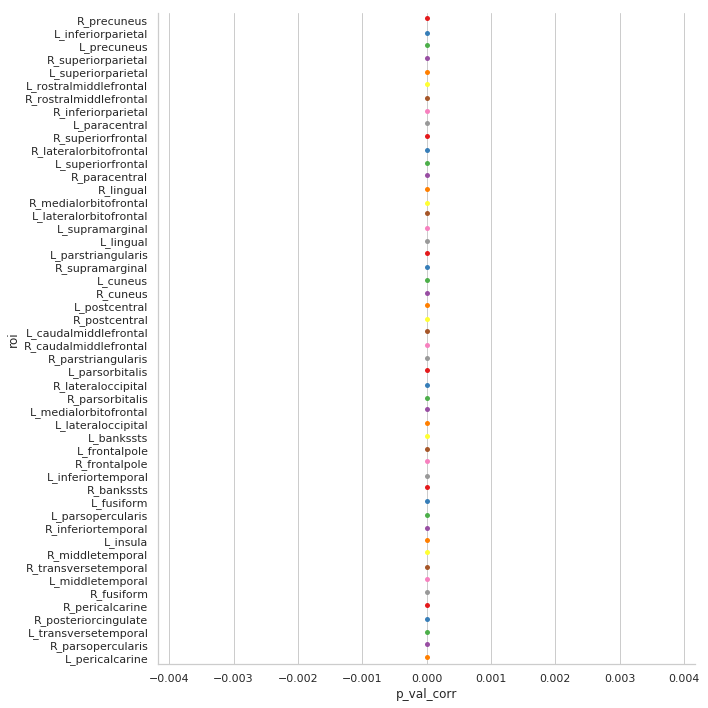

In [40]:
aparc = 'aparc' #aparc #Destrieux #Glasser
top_rois = 50
subx = sm_perf_file.rsplit('_',1)[1].split('.',1)[0]
print('Plots based on {} subjects'.format(subx))

if results_type == 'pipeline':
    plot_df = stat_perf.sort_values(by=[stat_measure]).head(top_rois)
    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',hue='pipeline',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");

else:
    plot_df = stat_perf[aparc].sort_values(by=['p_val']).head(top_rois)

    sns.set(font_scale=1)
    with sns.axes_style("whitegrid"):
        g = sns.catplot(x=stat_measure,y='roi',kind='strip',
                        data=plot_df,palette='Set1',height=10)
        #g.set(xscale="log");
        
print('Top 5 most significant regions {}'.format(plot_df.head(5)))

## PySurfer plots

In [41]:
# Plot configs

p_thresh = 0.001

if stat_measure == 'p_val':
    mult_comp = 'no_FDR'
elif stat_measure == 'p_val_corr':
    mult_comp = 'FDR'
else:
    print('unknown multiple comparison correction')
    mult_comp = 'unknown'

    
sm_perf_filename_split = sm_perf_file.split('.',1)[0].rsplit('_',2) 
brainmap_subdir = sm_perf_filename_split[0] + '_{}_'.format(mult_comp) + sm_perf_filename_split[1] + '_' + sm_perf_filename_split[2]

save_dir = brainmaps_dir + brainmap_subdir + '/'

if results_type == 'pipeline':
    pipes = ['fs51','fs53','fs60','civet','ants']
    aparcs = ['aparc']
    aparc = 'aparc' #For aggregating result cell 
    aparc_file = '.aparc.annot'
else:
    pipes = ['fs60']
    pipe = 'fs60' #For aggregating result cell 
    aparcs = ['aparc', 'Destrieux', 'Glasser']
    
# Pysurfer parameters
surf = 'inflated' #'white' #"inflated"
views = ['lateral','medial']

In [42]:
# Plot loops 
plot_style = {'colormap':'icefire','center':0}
for pipe in pipes:
    for aparc in aparcs:
        if results_type == 'pipeline':
            stat_df = stat_perf[stat_perf['pipeline']==pipe]
        else:
            stat_df = stat_perf[aparc]

        signific_rois = stat_df[stat_df[stat_measure] < p_thresh]['roi'].values
        signific_betas = stat_df[stat_df[stat_measure] < p_thresh]['coef'].values
        print('Number of signficant ROIs {}'.format(len(signific_rois)))

        plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(signific_rois,aparc,signific_betas)
        print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))
        
        if aparc == 'Glasser':
            aparc_file = '.HCP-MMP1.annot' 
        elif aparc == 'Destrieux':
            aparc_file = '.aparc.a2009s.annot' 
        elif aparc in ['aparc', 'DKT']:
            aparc_file = '.aparc.annot'
        else:
            aparc_file = ''
            print('Unknown cortical parcellation')

        for hemi in ['lh','rh']:
            if hemi=='lh':
                signific_rois = plot_regions_L
                betas = betas_L
            elif hemi=='rh':
                signific_rois = plot_regions_R
                betas = betas_R
            else: 
                print('Unknown hemisphere parameter')

            for view in views:
                title = '_{}_{}_{}_{}_{}_{}_N_{}'.format(pipe,aparc,surf,hemi,view,stat_measure,subx)
                brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                                save_dir,title,view,betas,plot_style)
                time.sleep(5) #Mayavi messes up if called to quickly
                

Number of signficant ROIs 62
plot regions 
left: ['bankssts', 'caudalanteriorcingulate', 'caudalmiddlefrontal', 'cuneus', 'fusiform', 'inferiorparietal', 'inferiortemporal', 'isthmuscingulate', 'lateraloccipital', 'lateralorbitofrontal', 'lingual', 'medialorbitofrontal', 'middletemporal', 'paracentral', 'parsopercularis', 'parsorbitalis', 'parstriangularis', 'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', 'precuneus', 'rostralanteriorcingulate', 'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal', 'supramarginal', 'frontalpole', 'transversetemporal', 'insula'], 
right: ['bankssts', 'caudalanteriorcingulate', 'caudalmiddlefrontal', 'cuneus', 'fusiform', 'inferiorparietal', 'inferiortemporal', 'isthmuscingulate', 'lateraloccipital', 'lateralorbitofrontal', 'lingual', 'medialorbitofrontal', 'middletemporal', 'paracentral', 'parsopercularis', 'parsorbitalis', 'parstriangularis', 'pericalcarine', 'postcentral', 'posteriorcingulate', 'precent

number of total vertices 163842 and ROIs 76
Using betas as colormap
number of significant rois 63
atlas: .aparc.a2009s.annot, signficant roi count: {-4.0284432558388295: 1151, 0.0: 32337, -2.815433915139072: 374, -11.387184846327857: 1243, -6.491289740595967: 1005, -3.27244713560957: 822, -4.731642498642925: 2536, -6.566182001568047: 932, -2.594040424768193: 1800, -4.51344540437038: 2607, -8.544377440421277: 2386, -2.806673004482344: 520, -6.339398202862638: 1881, -3.4008936218121146: 742, -12.089618205288945: 6591, -5.380746885801278: 1197, -3.076818362687841: 889, -5.051593940859849: 2463, -8.947213947599522: 3031, -6.45080048351319: 1111, -8.490720052558483: 8394, -7.207189588746671: 4914, -9.972366280960683: 1920, -6.142465607297863: 2171, -11.576725823259617: 4447, -7.334776981942612: 1957, -7.028965824336922: 818, -11.375326420623507: 2220, -4.115397656916912: 1454, -6.057095167762533: 1365, -5.204431525149845: 897, -2.05749573480472: 435, -2.3612236494437706: 496, -4.03558419945

Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_auto_FDR_N_960/surf_fs60_Destrieux_inflated_rh_medial_p_val_corr_N_960.png
Number of signficant ROIs 308
plot regions 
left: ['L_V1_ROI', 'L_MST_ROI', 'L_V6_ROI', 'L_V2_ROI', 'L_V3_ROI', 'L_V4_ROI', 'L_V8_ROI', 'L_3b_ROI', 'L_FEF_ROI', 'L_V3A_ROI', 'L_POS2_ROI', 'L_V7_ROI', 'L_IPS1_ROI', 'L_FFC_ROI', 'L_V3B_ROI', 'L_LO1_ROI', 'L_LO2_ROI', 'L_PIT_ROI', 'L_MT_ROI', 'L_A1_ROI', 'L_PSL_ROI', 'L_SFL_ROI', 'L_PCV_ROI', 'L_STV_ROI', 'L_7Pm_ROI', 'L_7m_ROI', 'L_POS1_ROI', 'L_23d_ROI', 'L_v23ab_ROI', 'L_d23ab_ROI', 'L_31pv_ROI', 'L_5m_ROI', 'L_5mv_ROI', 'L_23c_ROI', 'L_5L_ROI', 'L_24dd_ROI', 'L_24dv_ROI', 'L_7AL_ROI', 'L_SCEF_ROI', 'L_6ma_ROI', 'L_7Am_ROI', 'L_7PL_ROI', 'L_7PC_ROI', 'L_LIPv_ROI', 'L_VIP_ROI', 'L_MIP_ROI', 'L_1_ROI', 'L_2_ROI', 'L_3a_ROI', 'L_6mp_ROI', 'L_p24pr_ROI', 'L_a24pr_ROI', 'L_p32pr_ROI', 'L_a24_ROI', 'L_d32_ROI', 'L_8BM_ROI', 'L_p32_ROI',

Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_auto_FDR_N_960/surf_fs60_Glasser_inflated_lh_lateral_p_val_corr_N_960.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 153
atlas: .HCP-MMP1.annot, signficant roi count: {-5.830242898947164: 4181, 0.0: 36179, -2.495651548336928: 760, -2.0476255634041283: 698, -3.364076227548776: 1002, -4.633629037969681: 550, -3.131505069407871: 665, -3.93949918929212: 1173, -3.5012623003972188: 780, -4.007356647791459: 708, -6.583062492145779: 819, -2.767956169731858: 237, -2.3099307395519624: 394, -8.55163585672354: 1639, -3.763103864921179: 549, -6.127182559180511: 1765, -6.651567437938587: 357, -3.491197817226377: 832, -1.6586324719808265: 280, -2.512137369874257: 1176, -3.798821116803633: 552, -2.2882783117023857: 663, -3.800584910930193: 600, -5.922373933908833: 741, -6.365877458776697: 867, -4.657572172147866: 490,

Image saved at /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_auto_FDR_N_960/surf_fs60_Glasser_inflated_rh_lateral_p_val_corr_N_960.png
number of total vertices 163842 and ROIs 181
Using betas as colormap
number of significant rois 155
atlas: .HCP-MMP1.annot, signficant roi count: {0.0: 34242, -4.393363204705082: 568, -3.781190387463704: 1217, -3.6859722152874284: 1454, -2.153494326826577: 695, -2.888552421038229: 480, -3.824355650359957: 824, -4.6769582454710825: 752, -2.3470961501236043: 366, -6.030497773569118: 502, -3.6790892576505194: 733, -5.822298718023045: 1245, -8.028831408623997: 1083, -3.5244212770779444: 356, -4.642068582103281: 1083, -3.7440066026569085: 720, -5.362700965795291: 1681, -2.891649200168239: 760, -2.0748519397716123: 1050, -4.683006494896561: 533, -6.408497378393219: 532, -6.507046513265999: 1345, -4.972352371630622: 827, -5.90333477740788: 904, -3.1514842382644: 502, -2.6499871414903517: 

### Aggregate results

In [35]:
if results_type == 'pipeline':
    df_agg = aggregate_perf(stat_perf,stat_measure,results_type)
    agg_rois = df_agg['roi'].values
    agg_betas = df_agg['rank'].values
    print('Number of signficant ROIs {}'.format(len(agg_rois)))
    plot_regions_L,plot_regions_R,betas_L,betas_R = get_pysurfer_label_format(agg_rois,aparc,agg_betas)
    print('plot regions \nleft: {}, \nright: {}'.format(plot_regions_L,plot_regions_R))

    plot_style = {'colormap':plt.get_cmap('Set1'),'range':[0,5]}
    for hemi in ['lh','rh']:
        if hemi=='lh':
            signific_rois = plot_regions_L
            betas = betas_L
        elif hemi=='rh':
            signific_rois = plot_regions_R
            betas = betas_R
        else: 
            print('Unknown hemisphere parameter')

        for view in views:
            title = '_{}_{}_{}_{}_{}_{}_N_{}'.format('agg',aparc,surf,hemi,view,stat_measure,subx)
            brain_fig = create_surface_plot(common_space,hemi,surf,aparc_file,signific_rois,
                                            save_dir,title,view,betas,plot_style)

### Create plot montage

Reading images from /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/results/brainmaps/atlas_sm_perf_AGE_AT_SCAN_roi_ols_QC_auto_FDR_N_960/
Found 12 images
montage size (660, 880)


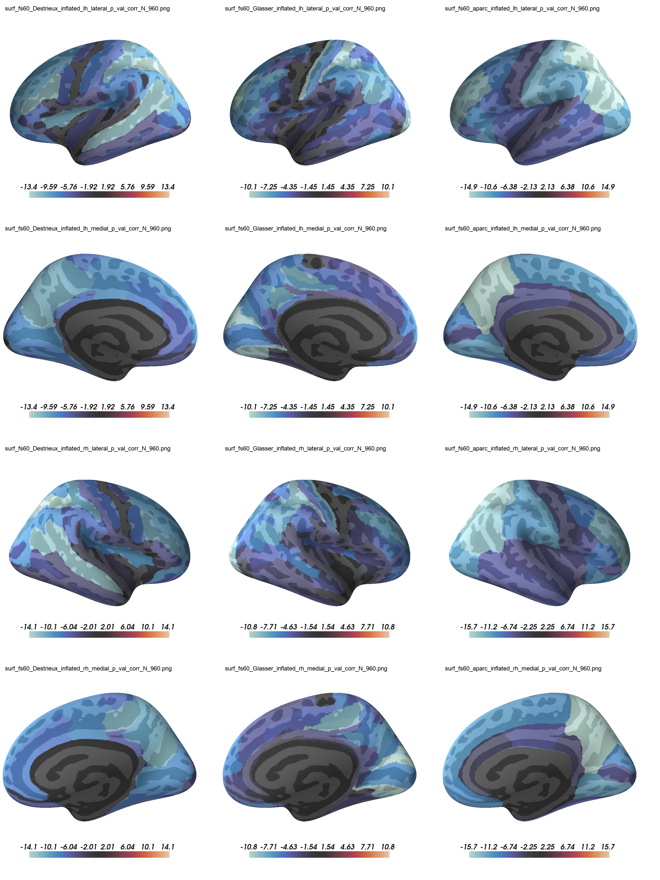

In [43]:
#plot_dir = brainmaps_dir + 'atlas_sm_perf_DX_GROUP_QC_gleb_FDR_N_225/'
plot_dir = save_dir
montage_im = createImageMontage(plot_dir)
montage_im

### Vertex plotting

In [5]:
# hemi = 'lh'
# view = 'medial'
N_signific = 500
analysis_type = 'clean'#either clean (OD) or comp (complete)
surf = 'inflated'
plot_dir = data_dir + 'outliers/highdim/visuals/'
save_path_template = plot_dir + 'test_brain_{}_{}.jpg'
aug_data = True

#cmap = plt.get_cmap('icefire'), #sns.diverging_palette(220, 10, as_cmap=True)
cmap = sns.xkcd_palette(["very light pink",'red']) 

analysis_files = ['coef_comp_con_{}','coef_clean_con_{}','coef_clean_con_him_{}']

for analysis_type in analysis_files:
    for hemi in ['lh','rh']:
        #input file
        f = 'df_index_{}.csv'.format(analysis_type).format(hemi) 
        sample_file = data_dir + 'outliers/highdim/{}'.format(f) 
        
        print('')
        print('Using outlier file: {}'.format(sample_file))

        sample_vdata = pd.read_csv(sample_file)
        for view in ['medial','lateral']:        
            #thickness_vals = np.max(sample_vdata.values[1:,1:], axis=0) #ignore header and index
            coef_data = sample_vdata['coef'].values
            N_nonzero = np.sum(coef_data != 0)
            N_signific_subset = np.min([N_signific, N_nonzero])
            coef_data_sorted_idx = coef_data.argsort()[-N_signific_subset:][::-1]
            print('Nonzero vertices avail {}, plotting {} '.format(N_nonzero, N_signific_subset))
            morph_data = np.zeros_like(coef_data)
            save_path = save_path_template.format(analysis_type.format(hemi),view)
            plot_surface_vertices(common_space,morph_data, coef_data_sorted_idx,aug_data,hemi,surf,view,cmap,save_path)


Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_lh.csv
Nonzero vertices avail 334, plotting 334 
Number of vertices to be plotted 334
Number of vertices to be plotted after augmentation 16700
5328.0
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/visuals/test_brain_coef_comp_con_lh_medial.jpg
Nonzero vertices avail 334, plotting 334 
Number of vertices to be plotted 334
Number of vertices to be plotted after augmentation 16700
5328.0
colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/visuals/test_brain_coef_comp_con_lh_lateral.jpg

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_rh.csv
Nonzero vertices avail 421, plotting 421 
Number of vertices to be pl

Reading images from /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/visuals/
Found 12 images
montage size (880, 660)


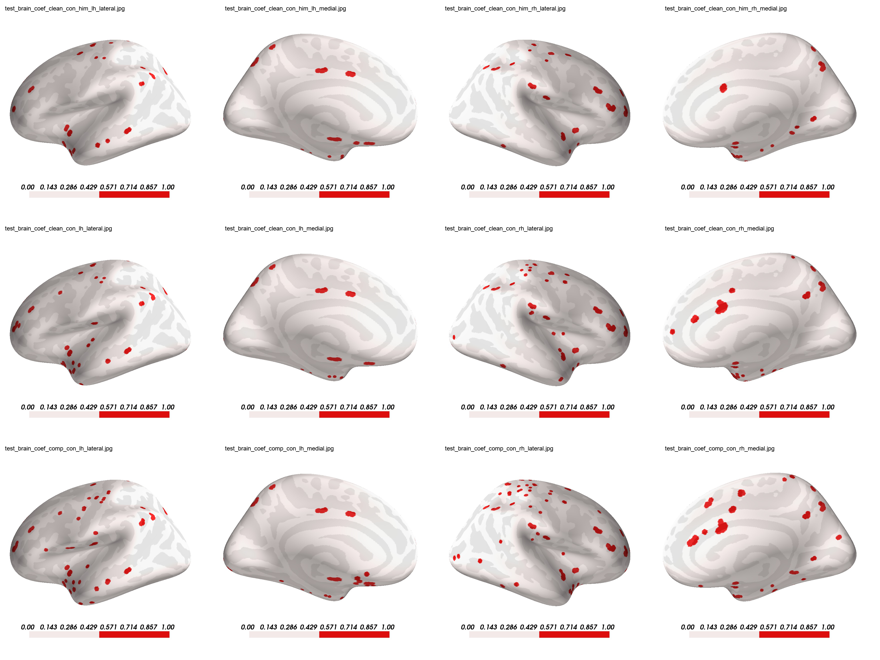

In [6]:
plot_dir = data_dir + 'outliers/highdim/visuals/'

montage_im = createImageMontage(plot_dir,num_img_views=4,transpose=True)
montage_im

### Get coordinate of top N significant ROIs

In [7]:
N_signific = 10
signific_df_concat = pd.DataFrame()
analysis_files = ['coef_comp_con_{}','coef_clean_con_{}','coef_clean_con_him_{}']
for analysis_type in analysis_files:
    for hemi in ['lh','rh']:
        #input file
        f = 'df_index_{}.csv'.format(analysis_type).format(hemi) 
        sample_file = data_dir + 'outliers/highdim/{}'.format(f) 
        
        print('')
        print('Using outlier file: {}'.format(sample_file))
        
        sample_vdata = pd.read_csv(sample_file)
        morph_data = np.abs(sample_vdata['coef'].values)
        morph_data_sorted_idx = morph_data.argsort()[-N_signific:][::-1]

        b = Brain(common_space, hemi, surf)
        x, y, z = b.geo[hemi].coords.T

        # ROI Labels
        aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],common_space, "label", hemi + '.aparc.annot')
        print('Using {} parcellation'.format(aparc_file))
        labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
        signific_labels = labels[morph_data_sorted_idx]
        signific_names = np.array(names)[signific_labels]

        signific_df = pd.DataFrame()
        signific_df['idx'] = morph_data_sorted_idx + 1
        signific_df['x'],signific_df['y'],signific_df['z'] = x[morph_data_sorted_idx],y[morph_data_sorted_idx],z[morph_data_sorted_idx]
        signific_df['roi_idx'] = signific_labels
        signific_df['roi_name'] = signific_names
        signific_df['hemi'] = np.tile(hemi,len(signific_df))
        signific_df['samples'] = np.tile(analysis_type.format(hemi),len(signific_df))
        signific_df['coef'] = morph_data[morph_data_sorted_idx]

        signific_df_concat = signific_df_concat.append(signific_df)


Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_lh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaverage/label/lh.aparc.annot parcellation

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_comp_con_rh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaverage/label/rh.aparc.annot parcellation

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_clean_con_lh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaverage/label/lh.aparc.annot parcellation

Using outlier file: /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/outliers/highdim/df_index_coef_clean_con_rh.csv
Using /home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/common_space/fsaver

In [8]:
signific_df_concat
#signific_df_concat.to_csv('/home/nikhil/Desktop/signficant_vertices_info_6files.csv')

,idx,x,y,z,roi_idx,roi_name,hemi,samples,coef
0,34551,-24.128948,-1.489648,41.427368,22,b'postcentral',lh,coef_comp_con_lh,0.592301
1,37490,34.087311,48.846249,20.897440,2,b'caudalanteriorcingulate',lh,coef_comp_con_lh,0.571519
2,18312,-23.381863,-5.907262,-4.400630,35,b'insula',lh,coef_comp_con_lh,0.561899
3,92570,3.463812,-10.150214,66.039818,24,b'precentral',lh,coef_comp_con_lh,0.554943
4,62112,28.030266,-55.648960,5.751086,25,b'precuneus',lh,coef_comp_con_lh,0.527958
5,143064,35.336605,-28.526398,4.935894,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.520918
6,62085,32.370636,-36.064564,18.484201,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.499091
7,25344,37.169491,-19.212038,9.191141,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.485607
8,48448,-21.969624,-3.662103,44.379936,22,b'postcentral',lh,coef_comp_con_lh,0.482522
9,120577,37.128284,-19.940786,8.086205,10,b'isthmuscingulate',lh,coef_comp_con_lh,0.476712
